I've written before about how much I enjoyed Andrew Ng's Coursera Machine Learning course. However, I also mentioned that I thought the course to be lacking a bit in the area of recommender systems. After learning basic models for regression and classification, recommmender systems likely complete the triumvirate of machine learning pillars for data science.

Working at an ecommmerce company, I think a lot about recommender systems and would like to provide an introduction to basic recommendation models. The goal of a recommendation model is to present a ranked list of objects given an input object. Typically, this ranking is based on the similarity between the input object and the listed objects. To be less vague, one often wants to either present similar products to a given product or present products that are personally recommended for a given user. 

The astounding thing is that if one has enough user-to-product data (ratings, purchases, etc...), then no other information is necessary to make decent recommendations. This is quite different than regression and classification problems where one must explore various features in order to boost a model's predictive powers. 

For this introduction, I'll use the MovieLens dataset - a classic dataset for training recommendation models. It can be obtained from the GroupLens website. There are various datasets, but the one that I will use below consists of 100,000 movie ratings by users (on a 1-5 scale). The main data file consists of a tab-separated list with user-id (starting at 1), item-id (starting at 1), rating, and timestamp as the four fields. We can use bash commands in the Jupyter notebook to download the file and then read it in with pandas. 

In [390]:
import numpy as np
import pandas as pd

In [391]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

In [392]:
cd ml-100k/

[Errno 2] No such file or directory: 'ml-100k/'
/home/ethan/Documents/webpage/blog/nbposts/ml-100k


In [393]:
ls

allbut.pl*  README   u1.test  u2.test  u3.test  u4.test  u5.test  ua.test  ub.test  u.genre  u.item        u.user
mku.sh*     u1.base  u2.base  u3.base  u4.base  u5.base  ua.base  ub.base  u.data   u.info   u.occupation


In [394]:
!head u.data
!echo # line break
!wc -l u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013

100000 u.data


In [395]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [396]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


Most recommendation models consist of building a user-by-item matrix with some sort of "interaction" number in each cell. If one includes the numerical ratings that users give items, then this is called an *explicit feedback* model. Alternatively, one may include *implicit feedback* which are actions by a user that signify a positive or negative preference for a given item (such as viewing the item online). These two scenarios often must be treated differently.

In the case of the MovieLens dataset, we have ratings so we will focus on explicit feedback models. First, we must construct our user-item matrix. We can easily map user/item ID's to user/item indices by removing the "Python starts at 0" offset between them.

In [397]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [398]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 6.30%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More approapriately, they are just empty entries. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [399]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[0, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [400]:
train, test = train_test_split(ratings)

## Collaborative filtering
We will focus on collaborative filtering models today which can be generally split into two classes: user- and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For user-based collaborative filtering, the user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items. 

A common distance metric is cosine similarity. The metric can be thought of geometrically if one treats a given user's (item's) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users' similarity is measured as the cosine of the angle between the two users' vectors. For users ${u}$ and ${u'}$, the cosine similarity is

$$
sim(u, u') = 
cos(\theta{}) = 
\frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = 
\sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} }
$$

This can be written as a for-loop with code, but the Python code will run quite slow; instead, one should try to express any equation in terms of NumPy functions. I've included a slow and fast version of the cosine similarity function below. The slow function took so long that I eventually canceled it because I got tired of waiting. The fast function, on the other hand, takes less than 200 ms. 

The cosine similarity will range from 0 to 1 in our case (because there are no negative ratings). Notice that it is symmetric and has ones along the diagonal.

In [401]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in xrange(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user'):
    if kind == 'user':
        sim = ratings.dot(ratings.T)
    elif kind == 'item':
        sim = ratings.T.dot(ratings)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

In [402]:
#%timeit slow_user_similarity(train)

In [403]:
%timeit fast_similarity(train, kind='user')

1 loops, best of 3: 197 ms per loop


In [404]:
user_similarity = fast_similarity(ratings, kind='user')
item_similarity = fast_similarity(ratings, kind='item')
print item_similarity[:4, :4]

[[ 1.          0.40238218  0.33024479  0.45493792]
 [ 0.40238218  1.          0.27306918  0.50257077]
 [ 0.33024479  0.27306918  1.          0.32486639]
 [ 0.45493792  0.50257077  0.32486639  1.        ]]


With our similarity matrix in hand, we can now predict the ratings that were not included with the data. Using these predictions, we can then compare them with the test data to attempt to validate the quality of our recommender model.

For user-based collaborative filtering, we predict that a user's $u$'s rating for item $i$ is given by the weighted sum of all other users' ratings for item $i$ where the weighting is the cosine similarity between the each user and the input user $u$.

$$\hat{r}_{ui} = \sum\limits_{u'}sim(u, u') r_{u'i}$$

We must also normalize by the number of ${r_{u'i}}$ ratings:

$$\hat{r}_{ui} = \frac{\sum\limits_{u'} sim(u, u') r_{u'i}}{\sum\limits_{u'}|sim(u, u')|}$$

As with before, our computational speed will benefit greatly by favoring NumPy functions over for loops. With our slow function below, even though I use NumPy methods, the presence of the for-loop still slows the algorithm


In [405]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [406]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

1 loops, best of 3: 41 s per loop


In [407]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

1 loops, best of 3: 350 ms per loop


We'll use the scikit-learn's mean squared error function as our validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives us a better result.

In [408]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [409]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 6.94323553669
Item-based CF MSE: 9.76822977653


### Top-$k$ Collaborative Filtering

We can attempt to improve our prediction MSE by only considering the top $k$ users who are most similar to the input user (or, similarly, the top $k$ items). That is, when we calculate the sums over $u'$

$$\hat{r}_{ui} = \frac{\sum\limits_{u'} sim(u, u') r_{u'i}}{\sum\limits_{u'}|sim(u, u')|}$$

we only sum over the top $k$ *most similar* users. A slow implementation of this algorithm is shown below. While I am sure that there is a way to use numpy sorting to get rid of the double for-loops, I got pretty frustrated desciphering the 2D argsort output and just settled for the slow loop.

As is shown below, employing this method actually halves our error!

In [410]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [411]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 3.4525394714
Top-k Item-based CF MSE: 4.06468373633


We can try tuning the parameter of $k$ to find the optimal value for minimizing our testing MSE. Here, it often helps to visualize the results to get a feeling for what's going on.

In [412]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

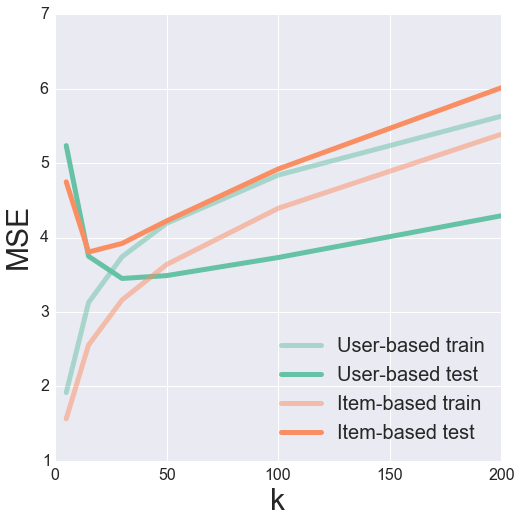

In [413]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

It looks like a *k* of around 30 produces a nice minimum in the test error for both user- and item-based collaborative filtering.

### Bias-subtracted Collaborative Filtering

For our last method of improving recommendations, we will try removing biases associated with either the user of the item. The idea here is that certain users may tend to always give high or low ratings to all movies. One could imagine that the *relative difference* in the ratings that these users give is more important than the *absolute* rating values.

Let us try subtracting each user's average rating when summing over similar user's ratings and then add that average back in at the end. Mathematically, this looks like

$$\hat{r}_{ui} = \bar{r_{u}} + \frac{\sum\limits_{u'} sim(u, u') (r_{u'i} - \bar{r_{u'}})}{\sum\limits_{u'}|sim(u, u')|}$$

where $\bar{r_{u}}$ is user $u$'s average rating.

In [414]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [415]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print 'Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test))

item_pred = predict_nobias(train, item_similarity, kind='item')
print 'Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test))

Bias-subtracted User-based CF MSE: 6.49061947142
Bias-subtracted Item-based CF MSE: 7.08351497126


### All together now

Finally, we can try combining both the Top-*k* and the Bias-subtracted algorithms. Strangely enough, this actually seems to perform worse than the original Top-*k* algorithm. Go figure.

In [416]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [417]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

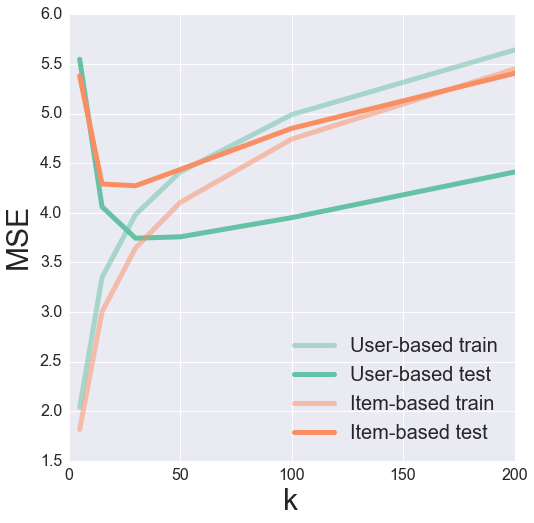

In [418]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## Validation

Having expanded upon the basic collaborative filtering algorithm, I have shown how we can reduce our mean squared error with increasing model complexity. However, how do we really know if we are making good recommendations? One thing that I glossed over was our choice of similarity metric. How do we know that cosine similarity was a good metric to use? Because we are dealing with a domain where many of us have intuition (movies), we can look at our item similarity matrix and see if similar items "make sense".

And just for fun, let us really *look* at the items. The MovieLens dataset contains a file with information about each movie. It turns out that there is a website called [themoviedb.org](https://www.themoviedb.org/) which has a free API. If we have the IMDB "movie id" for a movie, then we can use this API to return the posters of movies. Looking at the movie data file below, it seems that we at least have the IMDB url for each movie.

In [419]:
!head -5 u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


If you follow one of the links in this dataset, then your url will get redirected. The resulting url contains the IMDB movie ID as the last information in the url starting with "tt". For example, the redirected url for Toy Story is http://www.imdb.com/title/tt0114709/, and the IMDB movie ID is ```tt0114709```.

Using the Python requests library, we can automatically extract this movie ID. The Toy Story example is shown below.

In [420]:
import requests
import json

response = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
print response.url.split('/')[-2]

tt0114709


I requested a free API key from themoviedb.org. The key is necessary for querying the API. I've omitted it below, so be aware that if you will need your own key if you want to reproduce this. We can search for movie posters by movie id and then grab links to the image files. The links are relative paths, so we need the base_url query at the top of the next cell to get the full path. Also, some of the links don't work, so we can instead search for the movie by title and grab the first result.

In [496]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': 'PUT API_KEY HERE'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [489]:
from IPython.display import Image
from IPython.display import display

toy_story = 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'
Image(url=get_poster(toy_story, base_url))

Ta-da! Now we have a pipeline to go directly from the IMDB url in the data file to displaying the movie poster. With this machinery in hand, let us investigate our movie similarity matrix.

We can build a dictionary to map the movie-indices from our similarity matrix to the urls of the movies. We'll also create a helper function to return the top-*k* most similar movies given some input movie. With this function, the first movie returned will be the input movie (because of course it is the most similar to itself).

In [490]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [491]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)

In [492]:
display(*posters)

Hmmm, those recommendations do not seem too good! Let's look at a couple more.

In [493]:
idx = 1 # GoldenEye
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [494]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [495]:
idx = 40 # Billy Madison
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

As you can see, maybe we were not using such a good similarity matrix all along. Some of these recommendations are pretty bad - Star Wars is the most similar movie to Toy Story? No other James Bond movie in the top-5 most similar movies to GoldenEye?

One thing that could be the issue is that very popular movies like Star Wars are being favored. We can remove some of this bias by considering a different similarity metric - the pearson correlation. I'll just grab the built-in scikit-learn function for computing this.

In [497]:
from sklearn.metrics import pairwise_distances
# Convert from distance to similarity
item_correlation = 1 - pairwise_distances(ratings.T, metric='correlation') 

Let's look at these movies again.

In [498]:
idx = 0 # Toy Story
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [499]:
idx = 1 # GoldenEye
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [500]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [501]:
idx = 40 # Billy Madison
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

#### While the ordering changed some, we largely returned the same movies - now you can see why recommender systems are such a tricky beast! Next time we'll explore more advanced models and see how they affect the recommendations.